In [1]:
import numpy as np
import statsmodels.api as sm
import pickle
import fastparquet
import pandas_datareader as pdr
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import warnings
from numpy import array
from importlib import reload # to reload modules if we made changes to them without restarting kernel
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier, XGBRegressor # for features importance
from sklearn.metrics import precision_score, recall_score, accuracy_score
import functions
from feature_engineering import get_headlines

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 227 # native screen dpi for my computer

### Carregando dados

In [2]:
df = pd.read_parquet('data/eth.parquet')

In [3]:
df.head(3)

,const,close,volume,number_of_trades,target,return,change,volatility,momentum,rsi,macd,signal,upper_band,lower_band,lag_1,lag_2,ma_10,ma_30,ratio_ma,time
open_time,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:49:00,1.0,734.010010,252.489807,246,0.059263,0.0,0.040039,1.409659,730.330017,56.361752,0.279045,0.161656,734.673090,731.536418,0.005455,0.054498,733.502991,732.485659,1.001389,785540
2021-01-01 00:50:00,1.0,734.210022,268.051392,326,0.032959,0.0,0.200012,1.401633,730.609985,57.819760,0.320303,0.193385,734.707639,731.750444,0.027242,0.032695,733.553992,732.634660,1.001255,785541
2021-01-01 00:51:00,1.0,734.190002,198.461334,197,0.025607,-0.0,-0.020020,1.390473,730.969971,57.612274,0.347380,0.224184,734.811543,731.796065,-0.002727,0.024516,733.639990,732.752327,1.001211,785542


### Separando Treino e Teste

In [4]:
# 2020-07-01
test_treshold = '2020-01-01 00:00:00'

train = df[df.index < test_treshold]
test = df[df.index >= test_treshold]

X_train = train.drop(columns=['target'])
y_train = train['target']

X_test = test.drop(columns=['target'])
y_test = test['target']

In [5]:
# Tamanho dos DF
print('Número de observações Treino:', len(train))
print('Número de observações Teste:', len(test))
print('TOTAL:', len(df))

Número de observações Treino: 0
Número de observações Teste: 294536
TOTAL: 294536


## XGBoost

#### Executar para subir o jupyter com gerenciamento de memória
jupyter notebook --NotebookApp.max_buffer_size=536870912

In [32]:
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
plt.style.use('fivethirtyeight')

from datetime import datetime

In [132]:
test_treshold = '2021-07-20 00:00:00'
train_xgboost = df[df.index < test_treshold]
test_xgboost = df[df.index >= test_treshold]

X_train = train_xgboost.drop(columns=['target'])
y_train = train_xgboost['target']

X_test = test_xgboost.drop(columns=['target'])
y_test = test_xgboost['target']

In [133]:
# Tamanho dos DF
print('Número de observações Treino:', len(train))
print('Número de observações Teste:', len(test))
print('TOTAL:', len(df))

Número de observações Treino: 27360
Número de observações Teste: 7190
TOTAL: 294536


In [66]:
reg = xgb.XGBRegressor()

In [67]:
## Hyper Parameter Optimization Grid

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "n_estimators"     : [int(x) for x in np.linspace(start=100, stop=2000, num=10)],
 "min_child_weight" : [int(x) for x in np.arange(3, 15, 1)],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "subsample"        : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bylevel": [0.5, 0.6, 0.7, 0.8, 0.9, 1],  
 
}

In [68]:
xgboost_model  = RandomizedSearchCV(    
                reg,
                param_distributions=params,
                n_iter=10,
                n_jobs=-1,
                cv=5,
                verbose=3,
)

In [69]:
xgboost_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                                              0.8, 0.9, 1],
                                        'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                 

In [71]:
print(f"Model Best Score : {xgboost_model.best_score_}")
print(f"Model Best Parameters : {xgboost_model.best_estimator_.get_params()}")

Model Best Score : -0.6817681436435624
Model Best Parameters : {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.7, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.3, 'max_delta_step': 0, 'max_depth': 1, 'min_child_weight': 9, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1155, 'n_jobs': 12, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


In [72]:
xgboost_model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
             colsample_bynode=1, colsample_bytree=1, gamma=0.7, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=1,
             min_child_weight=9, missing=nan, monotone_constraints='()',
             n_estimators=1155, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:xlabel='open_time'>

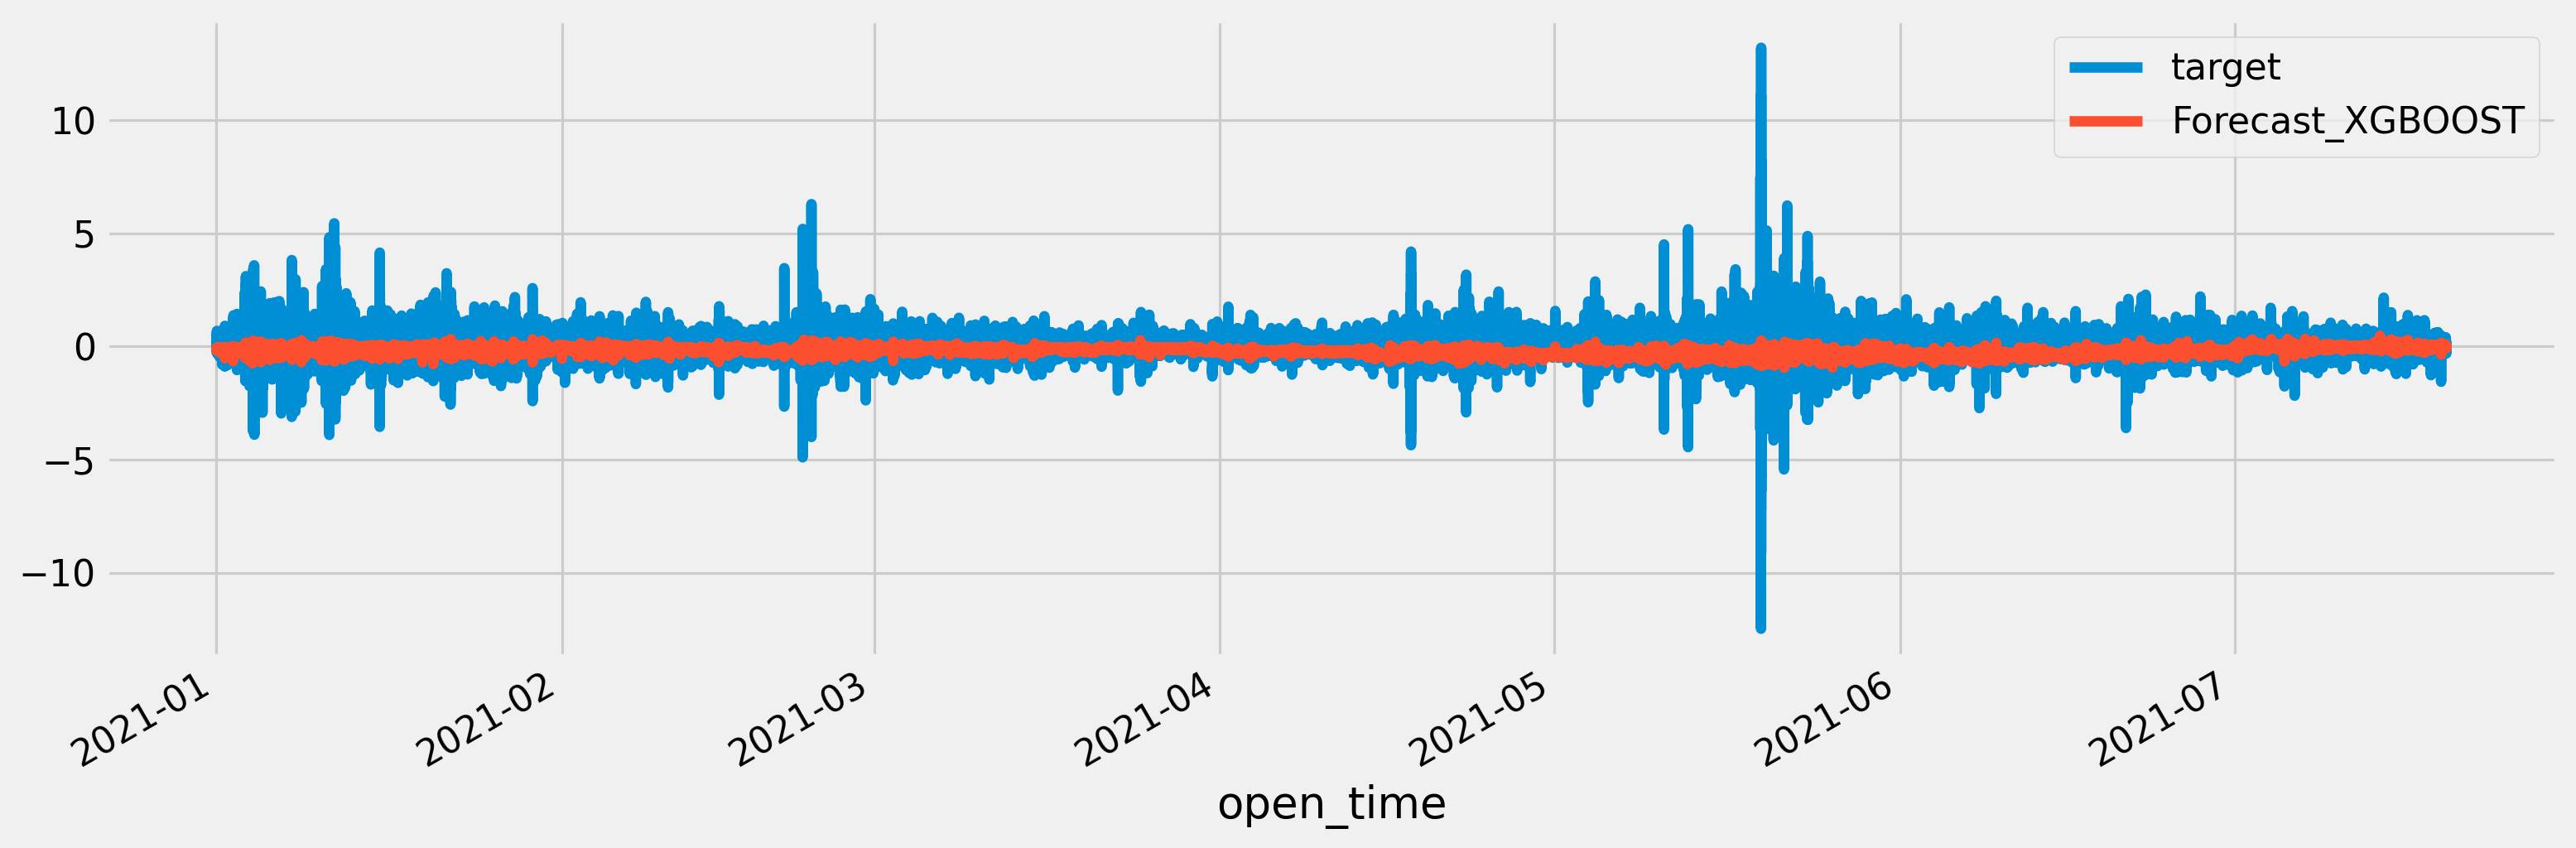

In [73]:
train_xgboost['Forecast_XGBOOST'] = xgboost_model.predict(X_train)

train_xgboost[['target','Forecast_XGBOOST']].plot(figsize=(15, 5))

In [75]:
test_xgboost['Forecast_XGBoost'] = xgboost_model.predict(X_test)

previsao_xgboost = pd.concat([train_xgboost, test_xgboost], sort=False)

<AxesSubplot:xlabel='open_time'>

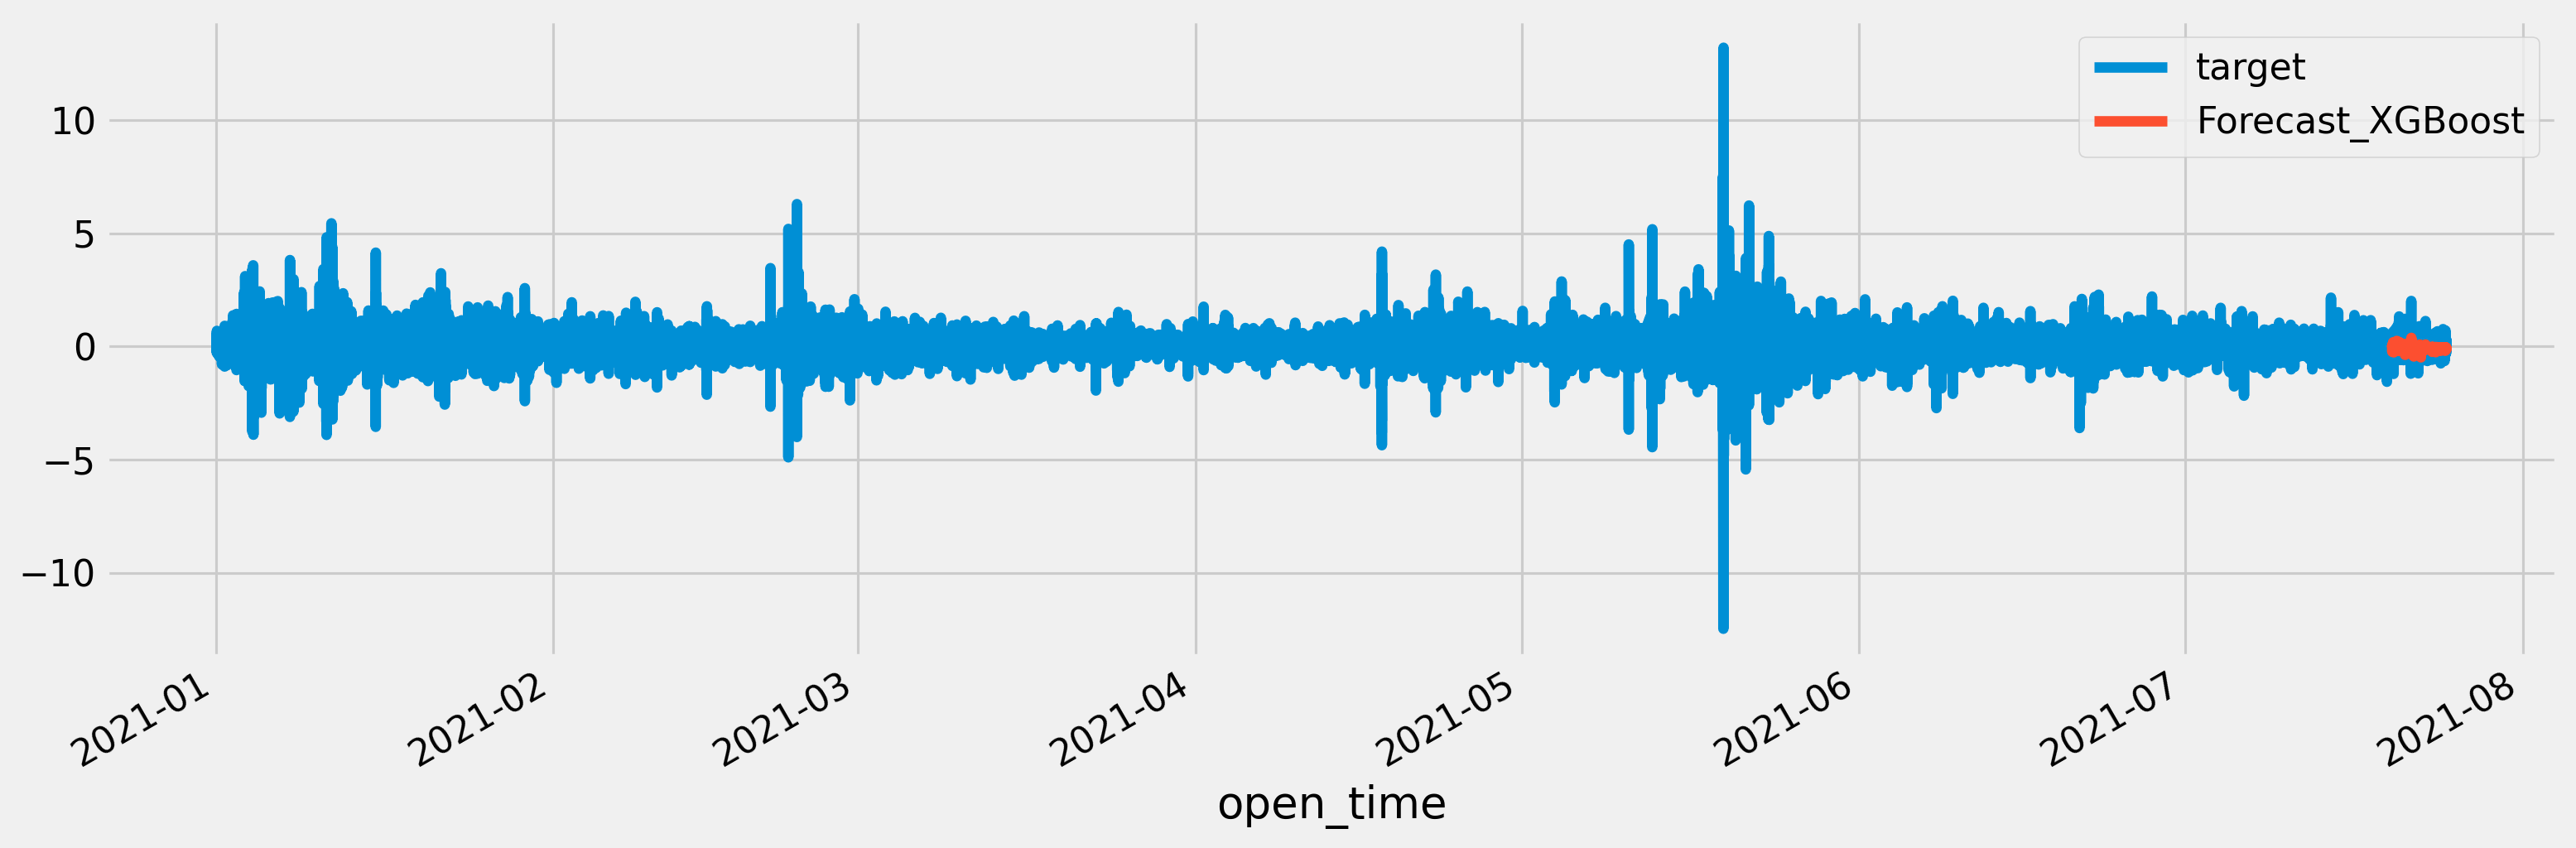

In [76]:
previsao_xgboost[['target','Forecast_XGBoost']].plot(figsize=(15, 5))

<AxesSubplot:xlabel='open_time'>

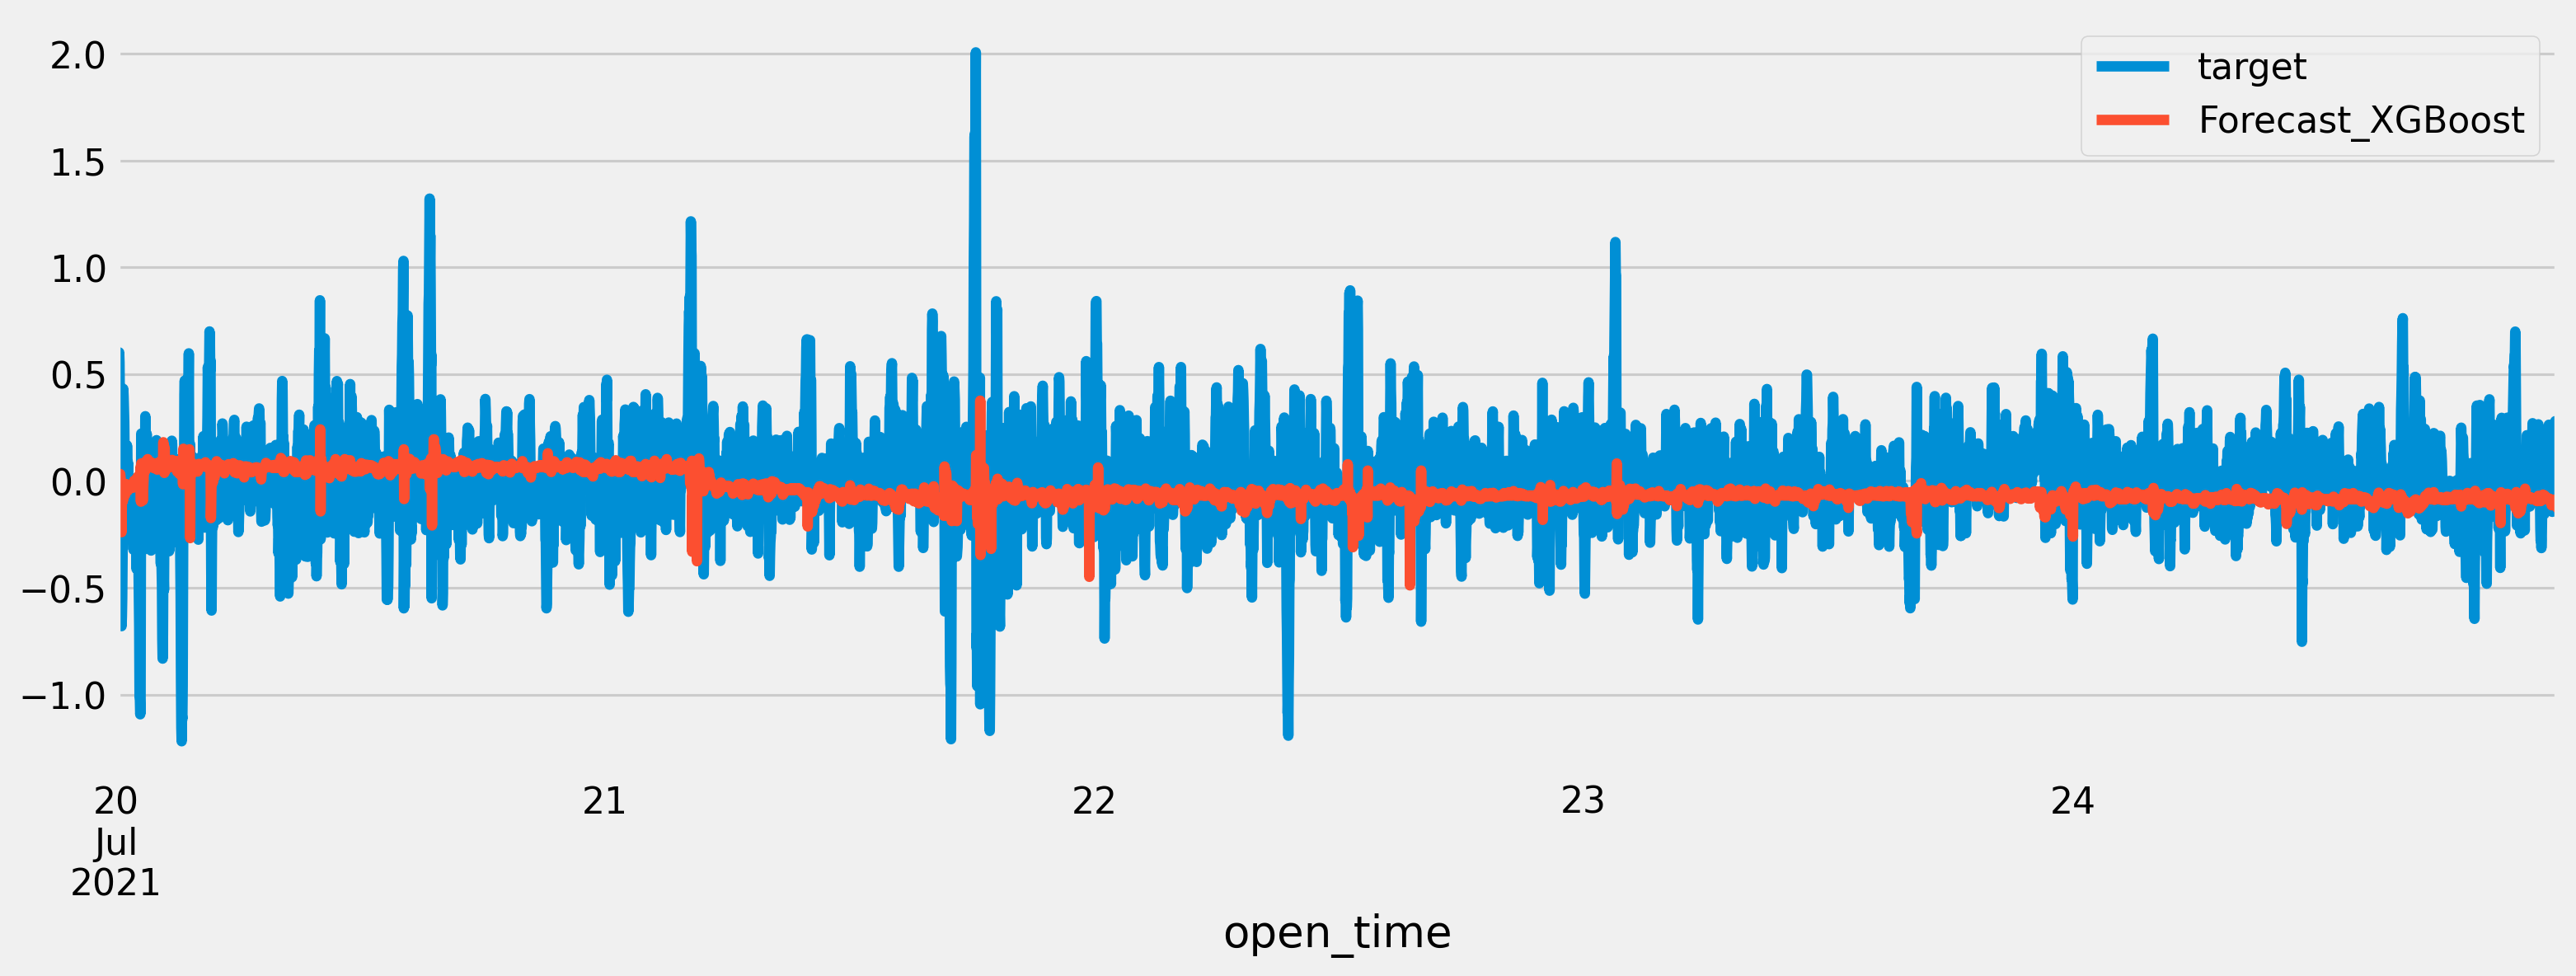

In [77]:
test_xgboost[['target','Forecast_XGBoost']].plot(figsize=(15, 5))

#### Resultado XGBOOST

In [78]:
train_mae = mean_absolute_error(train_xgboost['target'], train_xgboost['Forecast_XGBOOST'])
train_rmse = np.sqrt(mean_squared_error(train_xgboost['target'], train_xgboost['Forecast_XGBOOST']))
train_r2 = r2_score(train_xgboost['target'], train_xgboost['Forecast_XGBOOST'])
train_mse = mean_squared_error(train_xgboost['target'], train_xgboost['Forecast_XGBOOST'])

print(f"train MAE : {train_mae}")
print(f"train RMSE : {train_rmse}")
print(f"train R2 : {train_r2}")
print(f"train MSE : {train_mse}")

train MAE : 0.3172462602408487
train RMSE : 0.4464550020337119
train R2 : -0.37286787451240055


In [79]:
test_mae = mean_absolute_error(test_xgboost['target'], test_xgboost['Forecast_XGBoost'])
test_rmse = np.sqrt(mean_squared_error(test_xgboost['target'], test_xgboost['Forecast_XGBoost']))
test_r2 = r2_score(test_xgboost['target'], test_xgboost['Forecast_XGBoost'])
train_mse = mean_squared_error(test_xgboost['target'], test_xgboost['Forecast_XGBOOST'])

print(f"test MAE : {test_mae}")
print(f"test RMSE : {test_rmse}")
print(f"test R2 : {test_r2}")
print(f"test MSE : {test_mse}")

test MAE : 0.17337382452916825
test RMSE : 0.23742141334293965
test R2 : -0.1450351216086263
